<a href="https://colab.research.google.com/github/jmanuelmesa/PROYECTO-PREDICCI-N-DEL-PRECIO-DE-LA-ENERG-A-EN-LA-BOLSA/blob/main/01_Notebook_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
#Saving kaggle.json to kaggle.json
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
#

In [ ]:
! kaggle datasets list
! kaggle datasets download -d nicholasjhana/energy-consumption-generation-prices-and-weather

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
arnabchaki/data-science-salaries-2023                                 Data Science Salaries 2023 💸                         25KB  2023-04-13 09:55:16          21751        602  1.0              
mauryansshivam/netflix-ott-revenue-and-subscribers-csv-file           Netflix OTT Revenue and Subscribers (CSV File)        2KB  2023-05-13 17:40:23            908         24  1.0              
fatihb/coffee-quality-data-cqi                                        Coffee Quality Data (CQI May-2023)                   22KB  2023-05-12 13:06:39           2345         55  1.0              
darshanprabhu09/stock-prices-f

In [ ]:
! unzip /content/energy-consumption-generation-prices-and-weather.zip

Archive:  /content/energy-consumption-generation-prices-and-weather.zip
replace energy_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/ai4eng.v1/main/content/init.py
import init; init.init(force_download=False); init.get_weblink()

In [ ]:
#importamos las librerias a usar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
import local.lib.timeseries as ts
from sklearn.linear_model import LinearRegression
import seaborn as sns 
from google.colab import files

Leemos el archivo y definimos el tiempo como manera de indexar, para conveniencia

In [ ]:
df = pd.read_csv("/content/energy_dataset.csv")
df.index = pd.to_datetime(df.time)
del(df["time"])
pd.set_option("display.max_columns", None)


Hay algunas columnas que no poseen información, por lo que procederemos a eliminarlas directamente del data set. También reemplazamos los valores faltantes por cero, para no tener problemas a la hora de entrenar los modelos

In [ ]:
df_new = df.drop(df.iloc[:,[2,6,7,8,9,13,19,22]], axis=1)
df_new
df_new.fillna(0, inplace=True)
df_new.describe()


,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.305727,447.829198,5619.851072,4253.880903,298.158139,475.319644,971.589351,2603.777407,6260.870123,60.197667,85.595739,1431.930470,269.306126,5461.674595,1439.066735,5471.216689,28712.129962,28667.476928,49.874341,57.884023
std,85.796305,354.622834,2204.946787,1963.465684,52.963429,792.269198,401.307115,1835.677348,850.714243,20.279128,14.207003,1680.002043,50.572208,3215.250084,1677.703355,3176.312853,4594.100854,4664.083855,14.618900,14.204083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,237.000000,18105.000000,0.000000,2.060000,9.330000
25%,333.000000,0.000000,4125.000000,2524.750000,263.000000,0.000000,637.000000,1076.000000,5757.000000,53.000000,73.000000,70.000000,240.000000,2930.750000,69.000000,2979.000000,24793.750000,24800.000000,41.490000,49.347500
50%,367.000000,509.000000,4968.000000,4473.000000,300.000000,67.000000,905.000000,2163.000000,6563.500000,57.000000,88.000000,615.000000,279.000000,4847.000000,576.000000,4855.000000,28906.000000,28894.000000,50.520000,58.020000
75%,433.000000,757.000000,6428.000000,5837.000000,330.000000,615.000000,1250.000000,3756.250000,7024.000000,80.000000,97.000000,2575.250000,310.000000,7397.000000,2636.000000,7353.000000,32263.250000,32186.250000,60.530000,68.010000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,119.000000,5792.000000,357.000000,17436.000000,5836.000000,17430.000000,41390.000000,41015.000000,101.990000,116.800000


Como la variable que queremos predecir es el precio, harémos un histograma para visualizar como es el comportamiento, mirar de manera aproximada su distribución

Text(0, 0.5, 'Frecuencia')

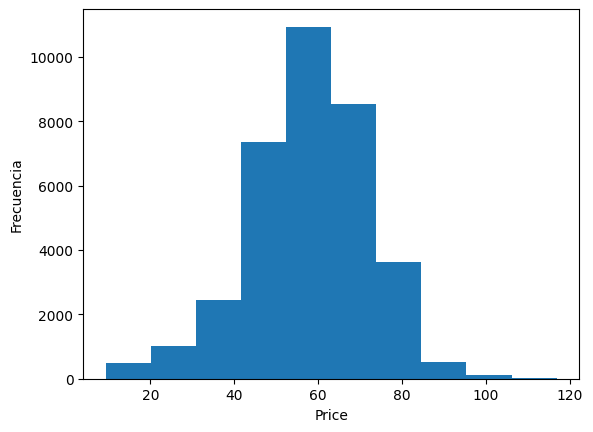

In [ ]:
plt.hist(df["price actual"])
plt.xlabel("Price")
plt.ylabel("Frecuencia")

Cabe decir que el precio de la electricidad es una serie de tiempo, que toma un valor cada hora, por lo que el primer modelo que usaremos es para predecir si sube o si baja, siguiendo una de las estrategias aprendidas en el curso, también se usa una libreria que esta en los notebooks del profesor


(34344, 722) (28000, 721) (6343, 721)


,price actual_0,price actual_1,price actual_2,price actual_3,price actual_4,price actual_5,price actual_6,price actual_7,price actual_8,price actual_9,price actual_10,price actual_11,price actual_12,price actual_13,price actual_14,price actual_15,price actual_16,price actual_17,price actual_18,price actual_19,price actual_20,price actual_21,price actual_22,price actual_23,price actual_24,price actual_25,price actual_26,price actual_27,price actual_28,price actual_29,price actual_30,price actual_31,price actual_32,price actual_33,price actual_34,price actual_35,price actual_36,price actual_37,price actual_38,price actual_39,price actual_40,price actual_41,price actual_42,price actual_43,price actual_44,price actual_45,price actual_46,price actual_47,price actual_48,price actual_49,price actual_50,price actual_51,price actual_52,price actual_53,price actual_54,price actual_55,price actual_56,price actual_57,price actual_58,price actual_59,price actual_60,price actual_61,price actual_62,price actual_63,price actual_64,price actual_65,price actual_66,price actual_67,price actual_68,price actual_69,price actual_70,price actual_71,price actual_72,price actual_73,price actual_74,price actual_75,price actual_76,price actual_77,price actual_78,price actual_79,price actual_80,price actual_81,price actual_82,price actual_83,price actual_84,price actual_85,price actual_86,price actual_87,price actual_88,price actual_89,price actual_90,price actual_91,price actual_92,price actual_93,price actual_94,price actual_95,price actual_96,price actual_97,price actual_98,price actual_99,price actual_100,price actual_101,price actual_102,price actual_103,price actual_104,price actual_105,price actual_106,price actual_107,price actual_108,price actual_109,price actual_110,price actual_111,price actual_112,price actual_113,price actual_114,price actual_115,price actual_116,price actual_117,price actual_118,price actual_119,price actual_120,price actual_121,price actual_122,price actual_123,price actual_124,price actual_125,price actual_126,price actual_127,price actual_128,price actual_129,price actual_130,price actual_131,price actual_132,price actual_133,price actual_134,price actual_135,price actual_136,price actual_137,price actual_138,price actual_139,price actual_140,price actual_141,price actual_142,price actual_143,price actual_144,price actual_145,price actual_146,price actual_147,price actual_148,price actual_149,price actual_150,price actual_151,price actual_152,price actual_153,price actual_154,price actual_155,price actual_156,price actual_157,price actual_158,price actual_159,price actual_160,price actual_161,price actual_162,price actual_163,price actual_164,price actual_165,price actual_166,price actual_167,price actual_168,price actual_169,price actual_170,price actual_171,price actual_172,price actual_173,price actual_174,price actual_175,price actual_176,price actual_177,price actual_178,price actual_179,price actual_180,price actual_181,price actual_182,price actual_183,price actual_184,price actual_185,price actual_186,price actual_187,price actual_188,price actual_189,price actual_190,price actual_191,price actual_192,price actual_193,price actual_194,price actual_195,price actual_196,price actual_197,price actual_198,price actual_199,price actual_200,price actual_201,price actual_202,price actual_203,price actual_204,price actual_205,price actual_206,price actual_207,price actual_208,price actual_209,price actual_210,price actual_211,price actual_212,price actual_213,price actual_214,price actual_215,price actual_216,price actual_217,price actual_218,price actual_219,price actual_220,price actual_221,price actual_222,price actual_223,price actual_224,price actual_225,price actual_226,price actual_227,price actual_228,price actual_229,price actual_230,price actual_231,price actual_232,price actual_233,price actual_234,price actual_235,price actual_236,price actual_237,price actual_238,price actual_239,price actual_240,price actual

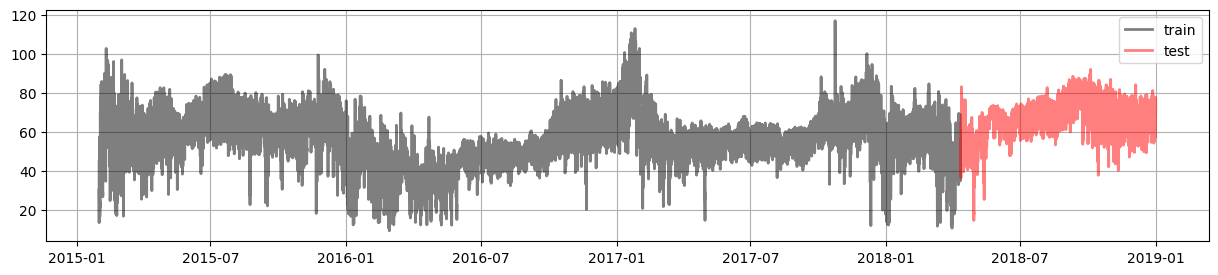

In [ ]:
#En un día hay 24 datos, tomaremos 720 para tener como referencia 30 días
dt = ts.timeseries_as_many2one(df.iloc[:,[0,-1]], columns=["price actual"], nb_timesteps_in=720, timelag=0)
dt_1 = dt.drop("generation biomass", axis=1)
#Usamos el criterio de 80% para entrenar y 20% para testear
train = dt_1[0:28000]
test = dt_1[28000:-1]
print (dt.shape, train.shape, test.shape)
plt.figure(figsize=(15,3))
plt.plot(train.index.values, train.iloc[:,-1],color="black", lw=2, label="train", alpha=.5)
plt.plot(test.index.values, test.iloc[:,-1], color="red", lw=2, label="test", alpha=.5)
plt.grid();
plt.legend();
dt_1

Luego de separar los datos de entrenamiento y de testeo, hay que formar los arrays correspondientes, ya que el modelo no los recibe como dataframe o serie de tiempo.

In [ ]:
#Generamos los arrays de x,y, train y test respectivamente
Xtr, ytr = train[[i for i in train.columns if i!="price actual"]].values, train.iloc[:,-1].values
Xts, yts = test[[i for i in test.columns if i!="price actual"]].values, test.iloc[:,-1].values
#Visualizamos los arrays para vigilar que sea lo esperado
print (Xtr[:10])
print (ytr[:10])

[[65.41 64.92 64.48 ... 60.29 54.74 45.04]
 [64.92 64.48 59.32 ... 54.74 45.04 30.14]
 [64.48 59.32 56.04 ... 45.04 30.14 24.91]
 ...
 [51.43 48.98 54.2  ... 14.27 13.85 13.48]
 [48.98 54.2  58.94 ... 13.85 13.48 16.37]
 [54.2  58.94 59.86 ... 13.48 16.37 27.33]]
[30.14 24.91 17.23 16.1  14.27 13.85 13.48 16.37 27.33 33.73]


Convertimos el objetivo en una tarea de predicción (1, aumenta el precio, 0 baja el precio)

In [ ]:
yts = (yts>Xts[:,-1]).astype(int)
ytr = (ytr>Xtr[:,-1]).astype(int)
print (ytr[:20])
print (yts[:20])

[0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1]
[0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0]


In [ ]:
print ("1's in train %.2f%s"%(np.mean(ytr)*100, "%"))
print ("1's in test  %.2f%s"%(np.mean(yts)*100, "%"))

1's in train 45.42%
1's in test  46.32%


Se importan las librerias necesarias para entrenar y medir el desempeño del modelo


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
estimator = RandomForestClassifier(n_estimators=5, max_depth=30)
estimator.fit(Xtr,ytr);



Mostramos la confusion Matrix, donde se presentan los verdaderos verdaderos, los falsos falsos, los verdaderos falsos y los falsos verdaderos. Es una manera de ver el deseñmpeño del modelo, posteriormente se muestra el acuraccy

Text(0.5, 1.0, 'Confusion Matrix')

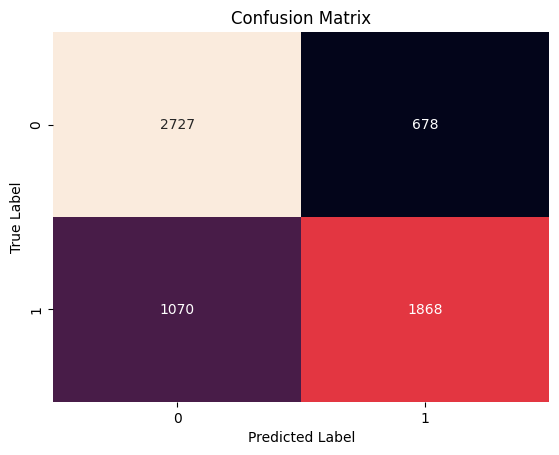

In [ ]:
cm = confusion_matrix(yts, estimator.predict(Xts))
sns.heatmap(cm,annot=True,cbar=False, fmt="d")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

In [ ]:
print ("train accuracy %.2f"%estimator.score(Xtr,ytr))
print ("test accuracy  %.2f"%estimator.score(Xts,yts))



train accuracy 0.97
test accuracy  0.72


Con algo más del 70% de acierto, nuestro modelo es aceptable para la tarea definida.

Para nuestro proximo modelo, primero analizaremos las correlaciones de las variables, y usaremos las más altas

In [ ]:
corr_matrix = df_new.corr()

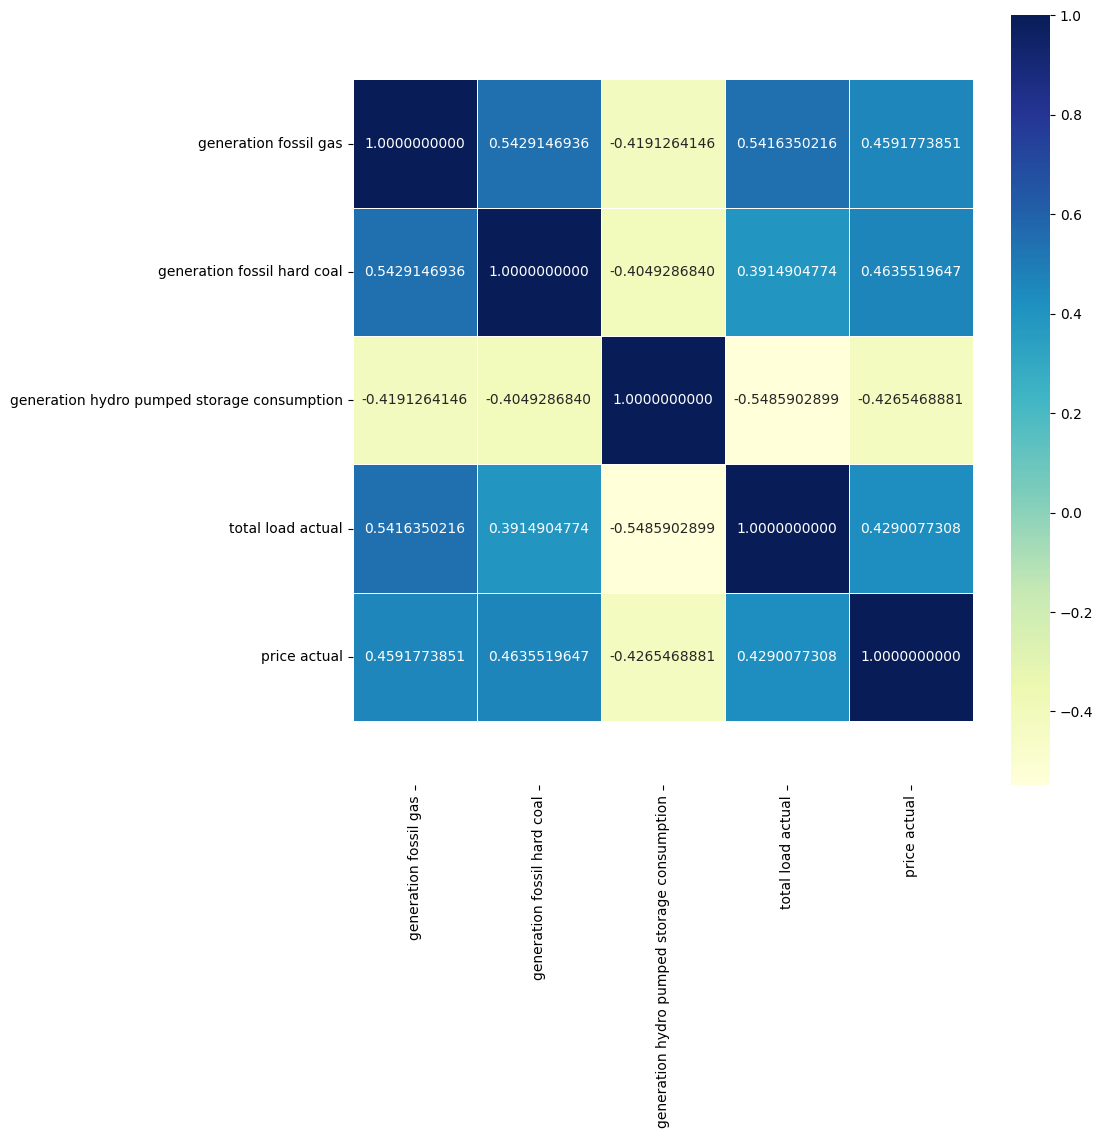

In [ ]:
#Obtuvimos que las que más se relacionan son las que se citan en la proxima gráfica
corr_matrix =  df_new[["generation fossil gas","generation fossil hard coal", "generation hydro pumped storage consumption","total load actual", "price actual"]].corr()
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(corr_matrix,
                 annot=True,
                 linewidths=0.5,
                 fmt=".10f",
                 cmap="YlGnBu");
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

xtrain = df_new[["generation fossil gas","generation fossil hard coal", "generation hydro pumped storage consumption","total load actual"]][0:28000]

Hay que recordar que nuestra variable dependiente en este caso será el precio, y los datos independientes para entrenar se pueden cambiar según la disponibilidad y el escenario que se quiera modelar

In [ ]:
#Nuevamente, seccioanamos los datos para entrenar y testear respectivamente
xtrain = df_new[["generation fossil gas","generation fossil hard coal", "generation hydro pumped storage consumption","total load actual"]][0:28000]
xtest = df_new[["generation fossil gas","generation fossil hard coal", "generation hydro pumped storage consumption","total load actual"]][28000:-1]
ytrain = (df_new["price actual"][0:28000]).values
ytest = (df_new["price actual"][28000:-1]).values
#Volvemos arrays las x, ya que estaban en formato de serie
x_train = xtrain[[i for i in xtrain.columns ]].values
x_test = xtest[[i for i in xtest.columns ]].values


Aplicamos el modelo, e imprimimos el score, pero no es la mejor manera de medir nuestro desempeño para este caso, más adelante se calculara el RMSL y se graficaran los datos predecidos y los de test para ver que el modelo funciona

In [ ]:
lr_model = LinearRegression()

lr_model.fit(x_train,ytrain)
print(lr_model.score(x_train,ytrain))




0.36265669085280106


In [ ]:
#El error rmsle corresponde al 23%, lo que nos da una confiabilidad en el modelo de 
#aproximadamente 77%, lo cual es bueno considerando las variables que se usaron
from sklearn.metrics import mean_squared_log_error
y_pred = lr_model.predict(x_test)



0.23582614796381376

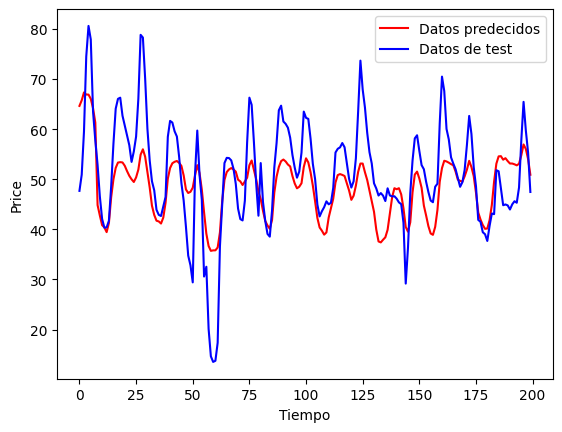

In [60]:
plt.plot(y_pred[0:200], color = "red", label = "Datos predecidos")
plt.plot(ytest[0:200],color = "blue" , label = "Datos de test")
plt.xlabel("Tiempo")
plt.ylabel("Price")
plt.legend()


In [ ]:
rmsle = np.sqrt(mean_squared_log_error(ytest, y_pred))
rmsle